In [12]:
import torchmetrics
import neural_net_model_train

import utils_data_load

train_loader = utils_data_load.train_loader
test_loader = utils_data_load.test_loader

input_size = (utils_data_load.X_train).shape[1]
number_of_classes = len(utils_data_load.labels_dict)

channels = 1
batch_size= 32

max_epochs = 70

args_model = {
    'number_of_classes':number_of_classes, 
    'input_shape' : (32, channels, input_size)
    }

models_trainning = neural_net_model_train.ModelsTrainning(
                    train_loader,
                    test_loader,
                    max_epochs)



def computeMean(values, mean_metric=torchmetrics.MeanMetric(nan_strategy="warn")):
    mean_metric.update(values)
    mean_value = mean_metric.compute()
    mean_metric.reset()

    return mean_value


In [13]:
import torch
# azure setting
torch.multiprocessing.set_sharing_strategy('file_system')


###  Trainning MLP model obtained from optimization with  evaluation function for accuracy

In [3]:
# the resulting params from optuna optimization:
model_parameters = """Params:                          
                  n_layers: 4                      
                  n_units_l0: 148
                  dropout_l0: 0.2394077234844161
                  n_units_l1: 85
                  dropout_l1: 0.1443158058026526
                  n_units_l2: 25
                  dropout_l2: 0.2711635652530161
                  n_units_l3: 94
                  dropout_l3: 0.16566341588513586
                  learning_rate: 7.481718442497427e-05
                  optimizer: RMSprop
                Evaluation function: accuracy"""

In [15]:
%reload_ext autoreload
%autoreload 2

import torch
from torch import nn

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
#the model is made from the best parameters found by optuna 
#and batchnorm is replaced by groupnorm
class MLP_Model(nn.Module):
    def __init__(self,args):
        super(MLP_Model, self).__init__()
        
        self.number_of_classes = args["number_of_classes"]
        self.input_shape = args["input_shape"]
        self.input_features=args["input_shape"][2]
        self.batch_size = args["input_shape"][0]
        
        
        self.fltn = nn.Flatten()
        
        self.fc1 = nn.Linear(self.input_features, 148)
        self.gp1 = nn.GroupNorm(num_groups = 37, num_channels= 148)
        self.lrelu1 = nn.LeakyReLU(inplace=True)
        self.drop1 =   nn.Dropout(p=0.24)

        self.fc2 = nn.Linear(148, 85)
        self.gp2 = nn.GroupNorm(num_groups=17,num_channels= 85)
        self.lrelu2 = nn.LeakyReLU(inplace=True)
        self.drop2 =   nn.Dropout(p=0.144)

        self.fc3 = nn.Linear(85, 25)
        self.gp3 = nn.GroupNorm(num_groups=5,num_channels= 25)
        self.lrelu3 = nn.LeakyReLU(inplace=True)
        self.drop3 =   nn.Dropout(p=0.27)

        self.fc4 = nn.Linear(25, 94)
        self.gp4 = nn.GroupNorm(num_groups=2,num_channels= 94)
        self.lrelu4 = nn.LeakyReLU(inplace=True)
        self.drop4 =   nn.Dropout(p=0.166)

        self.fc5 = nn.Linear(94, self.batch_size)
        
        self.initialize_weights()
        
    def forward(self, x):
        
        out = self.fc1(self.fltn(x))
        assert not torch.isnan(out).any()
        out = self.gp1(out)
        out = self.lrelu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        assert not torch.isnan(out).any()
        out = self.gp2(out)
        out = self.lrelu2(out)
        out = self.drop2(out)
        
        
        out = self.fc3(out)
        assert not torch.isnan(out).any()
        out = self.gp3(out)
        out = self.lrelu3(out)
        out = self.drop3(out)

        
        out = self.fc4(out)
        assert not torch.isnan(out).any()
        out = self.gp4(out)
        out = self.lrelu4(out)
        out = self.drop4(out)
        
        
        outputs = self.fc5(out)
        assert not torch.isnan(outputs).any()
        # print('-----------------------------')
        # out = self.logsm(out)
        
        outputs = outputs.view(self.batch_size, -1)
        linear_output = (nn.Linear(outputs.shape[1], self.number_of_classes)).to(DEVICE)
        
        # apply Linear to get shape of: (batch_size, number_of_classes)
        # the Linear is generated in this way to make the output fit the required shape and to let RNN layer be as wide as possible
        outputs = linear_output(outputs)
        
        # reshaped because  has to match the labels target
        outputs = outputs.unsqueeze(2)
        
        return outputs
    
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight.data, nonlinearity='leaky_relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)
                

In [6]:
# skip loading best model saved from optimization because has too many parameters 
def loadModel(mlp_model,optimizer,PATH = "best_optimized_models/mlp/accuracy/"+"mlp_13"):
    checkpoint = torch.load(PATH)
    mlp_model_ver1.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])


mlp_model_ver1 = MLP_Model(args_model)

optimizer = torch.optim.RMSprop(mlp_model_ver1.parameters(), lr=7.481718442497427e-05, alpha=0.99, eps=1e-08, centered=False)   


In [7]:
models_trainning.setParameters(
            net_model=mlp_model_ver1,
            optimizer=optimizer
        )

accuracies_scores, loss_scores, f1_scores, auroc_scores = models_trainning.trainNetModel()

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 55932/55932 [04:03<00:00, 229.97it/s]


In [8]:
print( "\nTrain set: Average loss: {:.4f}, Average accuracy: {:.4f}%,\n \t Average f1_score: {:.4f}, Average Area Under ROC: {:.4f} \n".format(
                computeMean(loss_scores),
                computeMean(accuracies_scores),
                computeMean(f1_scores),
                computeMean(auroc_scores),
            ), flush=True
        )

checkpoint = models_trainning.getModelCheckpoint()
torch.save(checkpoint, "best_optimized_models/mlp/accuracy/"+"mlp_trainned_"+ str(max_epochs))   




Train set: Average loss: 0.0666, Average accuracy: 2.7135%,
 	 Average f1_score: 0.0666, Average Area Under ROC: 0.5000 



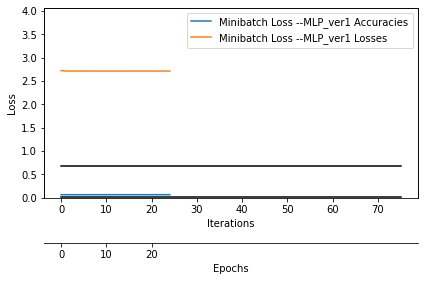

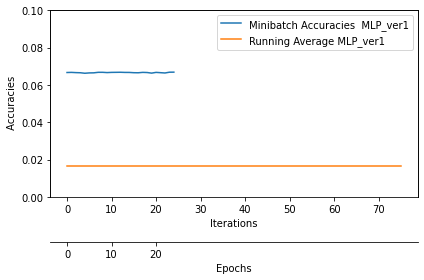

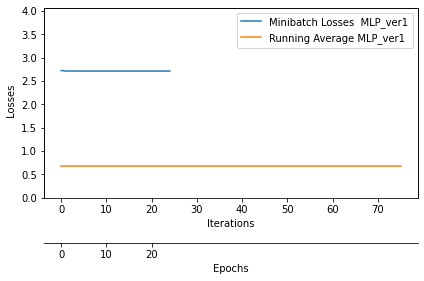

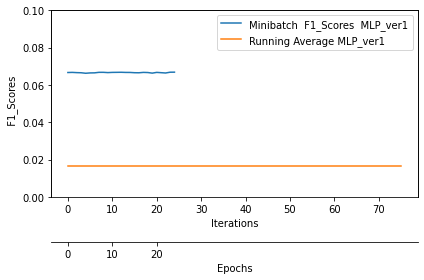

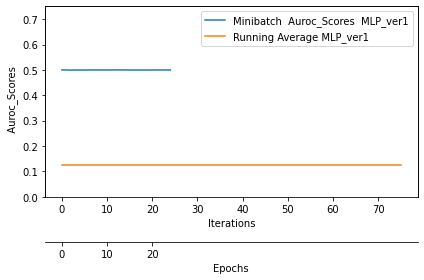

In [9]:
from utils.helper_plotting import plotEvaluationResults

plotEvaluationResults(accuracies_scores,loss_scores,f1_scores,auroc_scores,max_epochs, label="MLP_ver1")

In [10]:
# models_trainning.testNetModel()

loss_score, accuracies_scores, f1_scores , auroc_scores=neural_net_model_train.testNetModel(mlp_model_ver1, test_loader)

100%|██████████| 18951/18951 [00:56<00:00, 333.69it/s]


In [11]:
print(
        "\nTest set: Average loss: {:.4f}, Average accuracy: {:.4f}%,\n \t  Average f1_score: {:.4f}, Average Area Under ROC: {:.4f} \n".format(
            loss_score, accuracies_scores, f1_scores, auroc_scores
        ), flush=True
    )


Test set: Average loss: 2.7125, Average accuracy: 0.0690%,
 	  Average f1_score: 0.1164, Average Area Under ROC: 0.4954 



###  Trainning MLP model obtained from optimization with  evaluation function for f1_score

In [12]:
# the resulting params from optuna optimization:
model_parameters = """Params: 
                    n_layers: 7
                    n_units_l0: 115
                    dropout_l0: 0.21188057241438274
                    n_units_l1: 151
                    dropout_l1: 0.20908383005814535
                    n_units_l2: 139
                    dropout_l2: 0.17490465365600258
                    n_units_l3: 208
                    dropout_l3: 0.4351588652635723
                    n_units_l4: 34
                    dropout_l4: 0.31068252985882033
                    n_units_l5: 217
                    dropout_l5: 0.4612289778084963
                    n_units_l6: 58
                    dropout_l6: 0.14792666261716694
                    learning_rate: 0.00024636626958405986
                    optimizer: Adam
                  Evaluation function: f1_score"""

In [16]:
#the model is made from the best parameters found by optuna 
#and batchnorm is replaced by groupnorm
class MLP_ModelVer2(nn.Module):
    def __init__(self,args):
        super(MLP_ModelVer2, self).__init__()
        
        self.number_of_classes = args["number_of_classes"]
        self.input_shape = args["input_shape"]
        self.input_features=args["input_shape"][2]
        self.batch_size = args["input_shape"][0]
        
        self.fltn = nn.Flatten()
        
        self.fc1 = nn.Linear(self.input_features, 115)
        self.gp1 = nn.GroupNorm(num_groups = 23, num_channels= 115)
        self.lrelu1 = nn.LeakyReLU(inplace=True)
        self.drop1 =   nn.Dropout(p=0.21)

        self.fc2 = nn.Linear(115, 151)
        self.gp2 = nn.GroupNorm(num_groups=1,num_channels= 151)
        self.lrelu2 = nn.LeakyReLU(inplace=True)
        self.drop2 =   nn.Dropout(p=0.21)

        self.fc3 = nn.Linear(151, 139)
        self.gp3 = nn.GroupNorm(num_groups=1,num_channels= 139)
        self.lrelu3 = nn.LeakyReLU(inplace=True)
        self.drop3 =   nn.Dropout(p=0.175)

        self.fc4 = nn.Linear(139, 208)
        self.gp4 = nn.GroupNorm(num_groups=26,num_channels= 208)
        self.lrelu4 = nn.LeakyReLU(inplace=True)
        self.drop4 =   nn.Dropout(p=0.44)
        
        self.fc5 = nn.Linear(208, 34)
        self.gp5 = nn.GroupNorm(num_groups=2,num_channels= 34)
        self.lrelu5 = nn.LeakyReLU(inplace=True)
        self.drop5 =   nn.Dropout(p=0.31)
        
        self.fc6 = nn.Linear(34, 217)
        self.gp6 = nn.GroupNorm(num_groups=31,num_channels= 217)
        self.lrelu6 = nn.LeakyReLU(inplace=True)
        self.drop6 =   nn.Dropout(p=0.46)
        
        self.fc7 = nn.Linear(217, 58)
        self.gp7 = nn.GroupNorm(num_groups=2,num_channels= 58)
        self.lrelu7 = nn.LeakyReLU(inplace=True)
        self.drop7 =   nn.Dropout(p=0.148)

        self.fc8 = nn.Linear(58, self.batch_size)
        
        self.initialize_weights()
        
    def forward(self, x):
        
        out = self.fc1(self.fltn(x))
        assert not torch.isnan(out).any()
        out = self.gp1(out)
        out = self.lrelu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        assert not torch.isnan(out).any()
        out = self.gp2(out)
        out = self.lrelu2(out)
        out = self.drop2(out)
        
        
        out = self.fc3(out)
        assert not torch.isnan(out).any()
        out = self.gp3(out)
        out = self.lrelu3(out)
        out = self.drop3(out)

        
        out = self.fc4(out)
        assert not torch.isnan(out).any()
        out = self.gp4(out)
        out = self.lrelu4(out)
        out = self.drop4(out)
        
        
        out = self.fc5(out)
        assert not torch.isnan(out).any()
        out = self.gp5(out)
        out = self.lrelu5(out)
        out = self.drop5(out)
        
        
        out = self.fc6(out)
        assert not torch.isnan(out).any()
        out = self.gp6(out)
        out = self.lrelu6(out)
        out = self.drop6(out)
        
        
        out = self.fc7(out)
        assert not torch.isnan(out).any()
        out = self.gp7(out)
        out = self.lrelu7(out)
        out = self.drop7(out)
        
        
        outputs = self.fc8(out)
        assert not torch.isnan(outputs).any()
        # print('-----------------------------')
        # out = self.logsm(out)
        
        outputs = outputs.view(self.batch_size, -1)
        linear_output = (nn.Linear(outputs.shape[1], self.number_of_classes)).to(DEVICE)
        
        # apply Linear to get shape of: (batch_size, number_of_classes)
        # the Linear is generated in this way to make the output fit the required shape and to let RNN layer be as wide as possible
        outputs = linear_output(outputs)
        
        # reshaped because  has to match the labels target
        outputs = outputs.unsqueeze(2)
        
        return outputs
    
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight.data, nonlinearity='leaky_relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)
                

In [14]:


mlp_model_ver2 = MLP_ModelVer2(args_model)

optimizer = torch.optim.RMSprop(mlp_model_ver2.parameters(), lr=0.000246, alpha=0.99, eps=1e-08, centered=False)   

In [15]:
models_trainning.setParameters(
            net_model=mlp_model_ver2,
            optimizer=optimizer
        )

accuracies_scores, loss_scores, f1_scores, auroc_scores = models_trainning.trainNetModel()

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 55932/55932 [05:55<00:00, 157.48it/s]


In [16]:
print( "\nTrain set: Average loss: {:.4f}, Average accuracy: {:.4f}%,\n \t Average f1_score: {:.4f}, Average Area Under ROC: {:.4f} \n".format(
                computeMean(loss_scores),
                computeMean(accuracies_scores),
                computeMean(f1_scores),
                computeMean(auroc_scores),
            ), flush=True
        )

checkpoint = models_trainning.getModelCheckpoint()
torch.save(checkpoint, "best_optimized_models/mlp/f1_score/"+"mlp_trainned_"+ str(max_epochs))   


Train set: Average loss: 0.0667, Average accuracy: 2.7130%,
 	 Average f1_score: 0.0667, Average Area Under ROC: 0.5001 



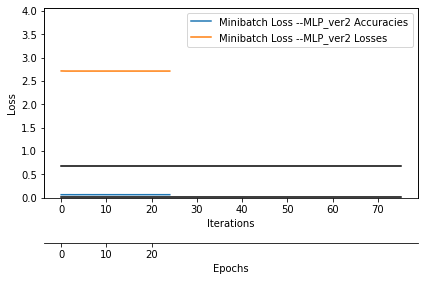

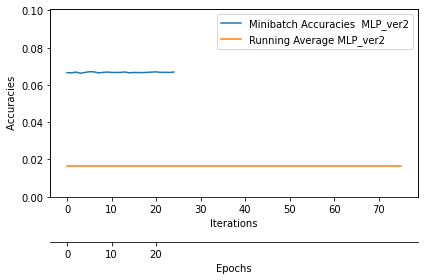

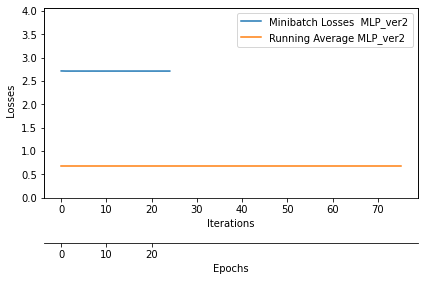

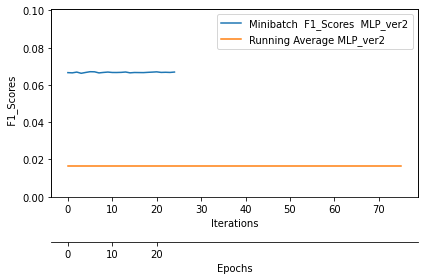

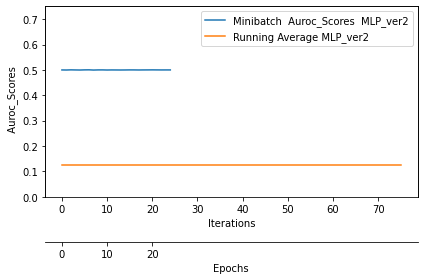

In [17]:
from utils.helper_plotting import plotEvaluationResults

plotEvaluationResults(accuracies_scores,loss_scores,f1_scores,auroc_scores,max_epochs, label="MLP_ver2")

In [18]:
# models_trainning.testNetModel()
loss_score, accuracies_scores, f1_scores , auroc_scores=neural_net_model_train.testNetModel(mlp_model_ver2, test_loader)


100%|██████████| 18951/18951 [01:14<00:00, 255.70it/s]


In [19]:
print(
        "\nTest set: Average loss: {:.4f}, Average accuracy: {:.4f}%,\n \t  Average f1_score: {:.4f}, Average Area Under ROC: {:.4f} \n".format(
            loss_score, accuracies_scores, f1_scores, auroc_scores
        ), flush=True
    )


Test set: Average loss: 2.7136, Average accuracy: 0.0673%,
 	  Average f1_score: 0.1133, Average Area Under ROC: 0.5073 



### Train the MLP model version 2 for 70 more epochs

In [17]:
mlp_model_ver2 = MLP_ModelVer2(args_model)
optimizer = torch.optim.RMSprop(mlp_model_ver2.parameters(), lr=0.000246, alpha=0.99, eps=1e-08, centered=False)   


max_epochs_prev=25
checkpoint = torch.load("best_optimized_models/mlp/f1_score/"+"mlp_trainned_"+ str(max_epochs_prev))
mlp_model_ver2.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])


In [18]:
models_trainning.setParameters(
            net_model=mlp_model_ver2,
            optimizer=optimizer
        )

accuracies_scores, loss_scores, f1_scores, auroc_scores = models_trainning.trainNetModel()

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 55932/55932 [06:22<00:00, 146.34it/s]


In [19]:
no_epochs = max_epochs + max_epochs_prev

checkpoint = models_trainning.getModelCheckpoint()
torch.save(checkpoint, "best_optimized_models/mlp/f1_score/"+"mlp_trainned_"+ str(no_epochs))   

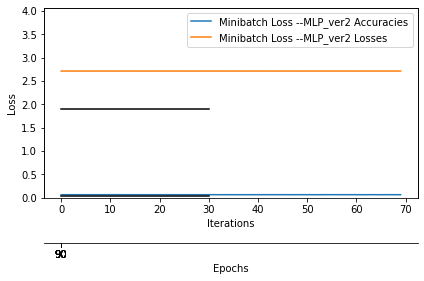

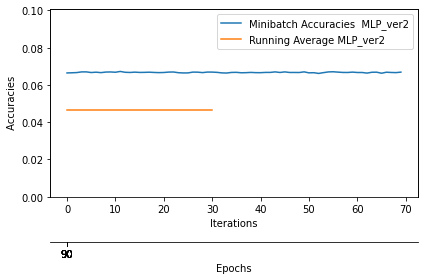

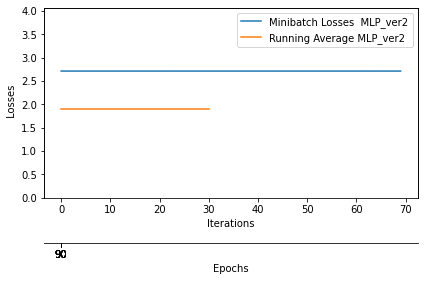

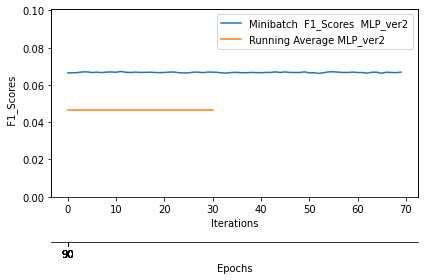

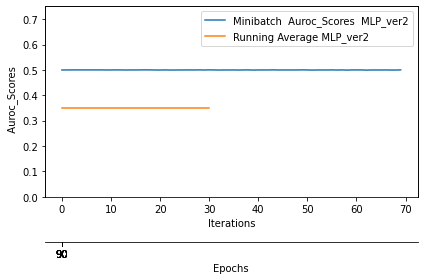

In [20]:
from utils.helper_plotting import plotEvaluationResults

plotEvaluationResults(accuracies_scores,loss_scores,f1_scores,auroc_scores,no_epochs, label="MLP_ver2")

In [21]:
# models_trainning.testNetModel()

loss_score, accuracies_scores, f1_scores , auroc_scores=neural_net_model_train.testNetModel(mlp_model_ver2, test_loader)

100%|██████████| 18951/18951 [01:24<00:00, 225.06it/s]


In [22]:
print(
        "\nTest set: Average loss: {:.4f}, Average accuracy: {:.4f}%,\n \t  Average f1_score: {:.4f}, Average Area Under ROC: {:.4f} \n".format(
            loss_score, accuracies_scores, f1_scores, auroc_scores
        ), flush=True
    )


Test set: Average loss: 2.7135, Average accuracy: 0.0671%,
 	  Average f1_score: 0.1134, Average Area Under ROC: 0.5053 

